### Настройка окружения и переменных окружения

In [71]:
# python 3.13

import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tecd_retail_recsys.data import download_tecd_data
from tecd_retail_recsys.data import DataPreprocessor
from tecd_retail_recsys.utils import calculate_avg_prices, calculate_overall_avg_price, get_avg_recs_price, get_item_to_price
from tecd_retail_recsys.metrics import calculate_metrics
from tecd_retail_recsys.models import TopPopular, TopPersonal, EASE, iALS, TIFUKNN


# HuggingFace token for downloading dataset
with open('hf_token.txt', 'r') as file:
    hf_token = file.read()
os.environ['HF_TOKEN'] = hf_token

In [2]:
%load_ext autoreload
%autoreload 2

### Загрузка и предобработка данных

In [3]:
# первичная загрузка данных

# download_tecd_data()

In [ ]:
# всего 227 дней данных в датасете
dp = DataPreprocessor(day_begin=1082, day_end=1308, val_days=20, test_days=20, min_user_interactions=1, min_item_interactions=20)
train_df, val_df, test_df = dp.preprocess()

Starting data preprocessing...
Loading events from t_ecd_small_partial/dataset/small/retail/events
Loaded 236,479,226 total events
Loading items data from t_ecd_small_partial/dataset/small/retail/items.pq
Loaded 250,171 items with features: ['item_id', 'item_brand_id', 'item_category', 'item_subcategory', 'item_price', 'item_embedding']
Merged item features. Data shape: (236479226, 12)
Filtered to 3,758,762 events with action_type='added-to-cart'
After filtering (min_user_interactions=1, min_item_interactions=20): 3,249,972 events, 84,944 users, 30,954 items
Created mappings: 84944 users, 30954 items
Temporal split - Train: days < 1269 (902,543 events), Val: days 1269-1288 (228,339 events), Test: days >= 1289 (223,395 events)
Users in each part (train, val, test) - 7425


`Оставляю только те айтемы, по которым есть хотя бы 20 взаимодействий, тем самым это позволит сократить часть данных и ускорить вычисления (что особенно полезно для модели EASE), снизит разреженность матрицы взаимодействий, сделает фокус на бизнес-релевантных товарах (товары с низкой частотой покупок часто являются нишевыми, сезонными или устаревшими позициями).`

In [5]:
train_df.head()

,timestamp,user_id,item_id,subdomain,action_type,os,day,item_brand_id,item_category,item_subcategory,item_price,item_embedding
1252,93485160,79038,20358,main,added-to-cart,android,1082,65693,Foodstuffs and Beverages,Dairy Products and Eggs,-5.766,"[-0.07660043, 0.07826791, 0.016526267, 0.02002..."
1336,93485187,44584,23489,item,added-to-cart,android,1082,60434,Foodstuffs and Beverages,Dairy Products and Eggs,-3.933,"[-0.046968337, 0.023347974, -0.057312813, 0.13..."
1453,93485221,12869,2908,item,added-to-cart,android,1082,240838,Foodstuffs and Beverages,Dairy Products and Eggs,-5.434,"[-0.053301465, 0.022747137, -0.040953826, 0.03..."
2144,93485421,42145,18904,search,added-to-cart,ios,1082,240838,Foodstuffs and Beverages,Seafood and Fish,-3.018,"[-0.09158996, 0.046439428, -0.05373656, 0.0606..."
2189,93485437,15304,14462,catalog,added-to-cart,android,1082,146468,Foodstuffs and Beverages,Culinary Additives and Seasonings,-4.207,"[-0.04469188, -0.036050983, -0.04374125, 0.077..."


In [58]:
# датафрейм формата: user_id - [(item_id1, timestamp1, price_item1), (item_id2, timestamp2, price_item2), ...]
joined = dp.get_grouped_data(train_df, val_df, test_df)
joined['train_val_interactions'] = joined['train_interactions'] + joined['val_interactions']
print(joined.shape)
joined.head(10)

(7425, 5)


,user_id,train_interactions,val_interactions,test_interactions,train_val_interactions
0,11,"[(8476, 95399246, -5.233), (7952, 95411006, -3...","[(8591, 110164749, -4.965), (4010, 110185189, ...","[(18369, 112022725, -4.692), (29875, 112032227...","[(8476, 95399246, -5.233), (7952, 95411006, -3..."
1,14,"[(11776, 98623953, -2.672), (11360, 98624852, ...","[(30789, 111213199, 0.0), (17585, 111242301, -...","[(8664, 111400827, -4.888), (10311, 111404767,...","[(11776, 98623953, -2.672), (11360, 98624852, ..."
2,21,"[(16067, 105087839, -3.838), (6548, 105089789,...","[(2195, 109690171, -4.252), (24455, 109704924,...","[(5535, 111584788, -3.207), (25886, 111614896,...","[(16067, 105087839, -3.838), (6548, 105089789,..."
3,29,"[(24855, 105300569, -3.779), (1228, 105347095,...","[(10268, 111157530, -4.484), (2169, 111175402,...","[(22555, 111565119, -4.273), (5342, 111585126,...","[(24855, 105300569, -3.779), (1228, 105347095,..."
4,39,"[(18478, 97610336, -3.804), (26949, 97898345, ...","[(30001, 110120451, -4.079), (19002, 110125294...","[(13391, 111576876, -4.481), (14124, 111591192...","[(18478, 97610336, -3.804), (26949, 97898345, ..."
5,50,"[(22366, 104572854, -4.391), (17179, 104575922...","[(4164, 110351806, -3.175), (9497, 110351936, ...","[(12641, 111581805, -4.464), (17127, 111591088...","[(22366, 104572854, -4.391), (17179, 104575922..."
6,57,"[(6646, 95313142, -1.849), (1916, 95315235, -3...","[(25291, 110102310, -4.253), (21758, 110107367...","[(17861, 112174473, -4.273), (27541, 112174676...","[(6646, 95313142, -1.849), (1916, 95315235, -3..."
7,72,"[(15625, 96009394, -4.815), (19585, 96016728, ...","[(27373, 109951487, -4.775), (12522, 109975279...","[(579, 111928617, -3.934), (11435, 111936448, ...","[(15625, 96009394, -4.815), (19585, 96016728, ..."
8,116,"[(4566, 103467223, -5.491), (13383, 103467594,...","[(8476, 110003862, -5.233), (30451, 110004188,...","[(16572, 111399181, -4.797), (10986, 111400880...","[(4566, 103467223, -5.491), (13383, 103467594,..."
9,118,"[(8034, 105509277, -4.229), (6010, 105511292, ...","[(7286, 109752777, -2.966), (4237, 109753233, ...","[(16561, 112147082, -4.354), (29369, 112169203...","[(8034, 105509277, -4.229), (6010, 105511292, ..."


In [60]:
joined_with_prices = calculate_avg_prices(joined)
joined_with_prices

,user_id,train_interactions,val_interactions,test_interactions,train_val_interactions,avg_train_price,avg_val_price,avg_test_price
0,11,"[(8476, 95399246, -5.233), (7952, 95411006, -3...","[(8591, 110164749, -4.965), (4010, 110185189, ...","[(18369, 112022725, -4.692), (29875, 112032227...","[(8476, 95399246, -5.233), (7952, 95411006, -3...",-4.275067,-4.524958,-4.245111
1,14,"[(11776, 98623953, -2.672), (11360, 98624852, ...","[(30789, 111213199, 0.0), (17585, 111242301, -...","[(8664, 111400827, -4.888), (10311, 111404767,...","[(11776, 98623953, -2.672), (11360, 98624852, ...",-3.507403,-1.670000,-2.976868
2,21,"[(16067, 105087839, -3.838), (6548, 105089789,...","[(2195, 109690171, -4.252), (24455, 109704924,...","[(5535, 111584788, -3.207), (25886, 111614896,...","[(16067, 105087839, -3.838), (6548, 105089789,...",-3.627373,-3.792690,-3.676510
3,29,"[(24855, 105300569, -3.779), (1228, 105347095,...","[(10268, 111157530, -4.484), (2169, 111175402,...","[(22555, 111565119, -4.273), (5342, 111585126,...","[(24855, 105300569, -3.779), (1228, 105347095,...",-3.656199,-3.879200,-3.805515
4,39,"[(18478, 97610336, -3.804), (26949, 97898345, ...","[(30001, 110120451, -4.079), (19002, 110125294...","[(13391, 111576876, -4.481), (14124, 111591192...","[(18478, 97610336, -3.804), (26949, 97898345, ...",-4.323336,-3.759429,-4.294471
...,...,...,...,...,...,...,...,...
7420,84871,"[(18376, 106539650, -3.135), (27108, 106544011...","[(18421, 109785795, -3.182), (26245, 109786759...","[(5658, 111459476, -3.794), (7239, 111460739, ...","[(18376, 106539650, -3.135), (27108, 106544011...",-3.558644,-3.583813,-3.673926
7421,84895,"[(4258, 106203864, -2.905), (26889, 106207347,...","[(11559, 109761572, -3.337), (27472, 109772659...","[(22878, 111566275, -4.964), (25118, 111590265...","[(4258, 106203864, -2.905), (26889, 106207347,...",-4.068484,-3.655855,-4.277292
7422,84903,"[(23387, 104669520, -3.011), (26838, 104677269...","[(8992, 109831567, -4.006), (8710, 109854832, ...","[(10545, 112536891, -3.864)]","[(23387, 104669520, -3.011), (26838, 104677269...",-3.409629,-3.744833,-3.864000
7423,84907,"[(1317, 103052276, -4.154), (12031, 103063040,...","[(8602, 109672611, -2.861), (23437, 109682344,...","[(20250, 111715486, -5.355), (22925, 111730913...","[(1317, 103052276, -4.154), (12031, 103063040,...",-3.459750,-3.939350,-4.218911


In [61]:
# Использование:
avg_train_price = calculate_overall_avg_price(joined, 'train_interactions')
avg_val_price = calculate_overall_avg_price(joined, 'val_interactions')
avg_test_price = calculate_overall_avg_price(joined, 'test_interactions')

print(f"Средняя цена в train: {avg_train_price:.2f}")
print(f"Средняя цена в val: {avg_val_price:.2f}")
print(f"Средняя цена в test: {avg_test_price:.2f}")

Средняя цена в train: -3.86
Средняя цена в val: -3.83
Средняя цена в test: -3.85


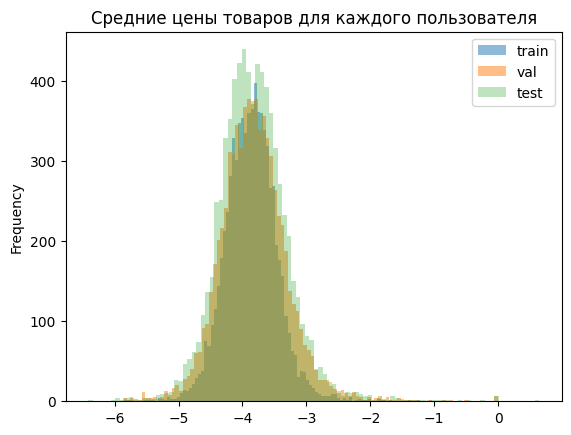

In [62]:
joined_with_prices['avg_train_price'].plot(kind='hist', bins=100, alpha=0.5, label='train')
joined_with_prices['avg_val_price'].plot(kind='hist', bins=100, alpha=0.5, label='val')
joined_with_prices['avg_test_price'].plot(kind='hist', bins=100, alpha=0.3, label='test')
plt.legend()
plt.title('Средние цены товаров для каждого пользователя')
plt.show()

In [63]:
joined_with_prices['avg_train_price'].mean(), joined_with_prices['avg_val_price'].mean(), joined_with_prices['avg_test_price'].mean()

(np.float64(-3.8646224431927845),
 np.float64(-3.8249169949247572),
 np.float64(-3.8297832301815755))

In [64]:
# разница средних цен между train, val и test
joined_with_prices['train_val_price_diff_abs'] = joined_with_prices['avg_val_price'] - joined_with_prices['avg_train_price']
joined_with_prices['train_val_price_diff_rel'] = (joined_with_prices['avg_val_price'] - joined_with_prices['avg_train_price']) / (joined_with_prices['avg_train_price'] + 1e-6)
joined_with_prices['val_test_price_diff_abs'] = joined_with_prices['avg_test_price'] - joined_with_prices['avg_val_price']
joined_with_prices['val_test_price_diff_rel'] = (joined_with_prices['avg_test_price'] - joined_with_prices['avg_val_price']) / (joined_with_prices['avg_val_price'] + 1e-6)
joined_with_prices['train_test_price_diff_abs'] = joined_with_prices['avg_test_price'] - joined_with_prices['avg_train_price']
joined_with_prices['train_test_price_diff_rel'] = (joined_with_prices['avg_test_price'] - joined_with_prices['avg_train_price']) / (joined_with_prices['avg_train_price'] + 1e-6)

# в процессе возникают случаи деления на 0, тогда относительные разницы будут равны огромным значениям, клипую по 1 и 99 персентилям
joined_with_prices['train_val_price_diff_rel'] = joined_with_prices['train_val_price_diff_rel'].clip(lower=joined_with_prices['train_val_price_diff_rel'].quantile(0.01), upper=joined_with_prices['train_val_price_diff_rel'].quantile(0.99))
joined_with_prices['val_test_price_diff_rel'] = joined_with_prices['val_test_price_diff_rel'].clip(lower=joined_with_prices['val_test_price_diff_rel'].quantile(0.01), upper=joined_with_prices['val_test_price_diff_rel'].quantile(0.99))
joined_with_prices['train_test_price_diff_rel'] = joined_with_prices['train_test_price_diff_rel'].clip(lower=joined_with_prices['train_test_price_diff_rel'].quantile(0.01), upper=joined_with_prices['train_test_price_diff_rel'].quantile(0.99))

joined_with_prices.head(3)

,user_id,train_interactions,val_interactions,test_interactions,train_val_interactions,avg_train_price,avg_val_price,avg_test_price,train_val_price_diff_abs,train_val_price_diff_rel,val_test_price_diff_abs,val_test_price_diff_rel,train_test_price_diff_abs,train_test_price_diff_rel
0,11,"[(8476, 95399246, -5.233), (7952, 95411006, -3...","[(8591, 110164749, -4.965), (4010, 110185189, ...","[(18369, 112022725, -4.692), (29875, 112032227...","[(8476, 95399246, -5.233), (7952, 95411006, -3...",-4.275067,-4.524958,-4.245111,-0.249892,0.058453,0.279847,-0.061845,0.029956,-0.007007
1,14,"[(11776, 98623953, -2.672), (11360, 98624852, ...","[(30789, 111213199, 0.0), (17585, 111242301, -...","[(8664, 111400827, -4.888), (10311, 111404767,...","[(11776, 98623953, -2.672), (11360, 98624852, ...",-3.507403,-1.670000,-2.976868,1.837403,-0.396011,-1.306868,0.667140,0.530535,-0.151262
2,21,"[(16067, 105087839, -3.838), (6548, 105089789,...","[(2195, 109690171, -4.252), (24455, 109704924,...","[(5535, 111584788, -3.207), (25886, 111614896,...","[(16067, 105087839, -3.838), (6548, 105089789,...",-3.627373,-3.792690,-3.676510,-0.165317,0.045575,0.116180,-0.030633,-0.049137,0.013546


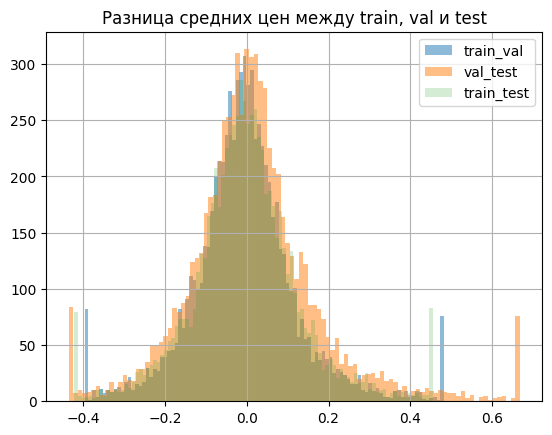

In [66]:
joined_with_prices['train_val_price_diff_rel'].hist(bins=100, alpha=0.5, label='train_val')
joined_with_prices['val_test_price_diff_rel'].hist(bins=100, alpha=0.5, label='val_test')
joined_with_prices['train_test_price_diff_rel'].hist(bins=100, alpha=0.2, label='train_test')
plt.legend()
plt.title('Разница средних цен между train, val и test')
plt.show()

In [67]:
joined_with_prices['train_test_price_diff_rel'].quantile([0.025, 0.5, 0.975])

0.025   -0.290942
0.500   -0.006029
0.975    0.314059
Name: train_test_price_diff_rel, dtype: float64

**Выводы по данной части:**

0. Имея информацию о ценах товаров мы можем сравнивать рекомендации относительно среднего чека пользователя и относительно других рекомендаций - искать наиболее выгодные рекомендации бизнесу. Жаль нет информации о маржинальности товаров :/
1. Средние цены товаров у каждого пользователя распределены нормально (в среднем айтем стоит около -3.86 в потребительской корзине).
2. Разница цен товаров между train, val, test тоже распределена нормально (гиперинфляции не наблюдаем юху). 95% доверительный интервал показывает, что в средний чек пользователя между трейном и тестом меняется не более, чем на 30%. Медианное же значение - 0%.

In [79]:
# потребуется для вычисления средней цены рекомендаций
item_to_price = get_item_to_price(dp)

### Baseline-models

- Top-Popular
- Top-Personal
- EASE
- iALS
- TIFU-KNN

#### TopPopular

In [80]:
# обучаем на трейне, предсказываем на валидации
toppop_val = TopPopular()
toppop_val.fit(joined, col='train_interactions')
joined['toppopular_recs_val'] = toppop_val.predict(joined, topn=100)

# обучаем на трейне+валидации, предсказываем на тесте
toppop_test = TopPopular()
toppop_test.fit(joined, col='train_val_interactions')
joined['toppopular_recs_test'] = toppop_test.predict(joined, topn=100)

In [81]:
print('Метрики на валидацинной выборке:')
val_metrics_toppop = calculate_metrics(joined, model_preds='toppopular_recs_val', gt_col='val_interactions', verbose=True)

print('\nМетрики на тестовой выборке:')
test_metrics_toppop = calculate_metrics(joined, model_preds='toppopular_recs_test', gt_col='test_interactions', verbose=True)

Метрики на валидацинной выборке:
NDCG@10 = 0.1028
Recall@10 = 0.0143
NDCG@100 = 0.3173
Recall@100 = 0.0767

Метрики на тестовой выборке:
NDCG@10 = 0.1062
Recall@10 = 0.0156
NDCG@100 = 0.2904
Recall@100 = 0.0694


In [87]:
avg_toppop_recs_price_val = get_avg_recs_price(joined, item_to_price, 'toppopular_recs_val')
print(f'Средняя цена рекомендаций модели TopPopular на валидации: {avg_toppop_recs_price_val}')

avg_toppop_recs_price_test = get_avg_recs_price(joined, item_to_price, 'toppopular_recs_test')
print(f'Средняя цена рекомендаций модели TopPopular на тесте: {avg_toppop_recs_price_test}')

Средняя цена рекомендаций модели TopPopular на валидации: -3.7024772184515995
Средняя цена рекомендаций модели TopPopular на тесте: -3.671278410702898


`В целом отличные метрики для TopPopular: NDCG@100=0.3173 на валидации и 0.2872 на тестовых данных! Так еще и предсказываем более дорогие, чем средняя цена в нашем ассортименте!`

#### TopPersonal

In [88]:
# обучаем на трейне, предсказываем на валидации
toppers_val = TopPersonal()
toppers_val.fit(joined, col='train_interactions')
joined['toppersonal_recs_val'] = toppers_val.predict(joined, topn=100)

# обучаем на трейне+валидации, предсказываем на тесте
toppers_test = TopPersonal()
toppers_test.fit(joined, col='train_val_interactions')
joined['toppersonal_recs_test'] = toppers_test.predict(joined, topn=100)

In [89]:
print('Метрики на валидацинной выборке:')
val_metrics_toppers = calculate_metrics(joined, model_preds='toppersonal_recs_val', gt_col='val_interactions', verbose=True)

print('\nМетрики на тестовой выборке:')
test_metrics_toppers = calculate_metrics(joined, model_preds='toppersonal_recs_test', gt_col='test_interactions', verbose=True)

Метрики на валидацинной выборке:
NDCG@10 = 0.2965
Recall@10 = 0.0659
NDCG@100 = 0.4391
Recall@100 = 0.1647

Метрики на тестовой выборке:
NDCG@10 = 0.3112
Recall@10 = 0.0728
NDCG@100 = 0.4807
Recall@100 = 0.1903


In [90]:
avg_toppers_recs_price_val = get_avg_recs_price(joined, item_to_price, 'toppersonal_recs_val')
print(f'Средняя цена рекомендаций модели TopPersonal на валидации: {avg_toppers_recs_price_val}')

avg_toppers_recs_price_test = get_avg_recs_price(joined, item_to_price, 'toppersonal_recs_test')
print(f'Средняя цена рекомендаций модели TopPersonal на тесте: {avg_toppers_recs_price_test}')

Средняя цена рекомендаций модели TopPersonal на валидации: -3.0065221532331985
Средняя цена рекомендаций модели TopPersonal на тесте: -3.1741887019691704


`Смогли неплохо так вырастить метрики! Но при этом средняя цена рекомендаций выросла - начали рекомендовать более дорогие товары.`

#### EASE

In [100]:
# создадим матрицу интеракций
matrix_train, idx_to_item_train = dp.get_interactions_matrix(joined, col='train_interactions')
print(matrix_train.shape)

matrix_train_val, idx_to_item_train_val = dp.get_interactions_matrix(joined, col='train_val_interactions')
print(matrix_train_val.shape)

(7425, 30751)
(7425, 30923)


In [103]:
# обучаем на трейне, предсказываем на валидации
ease_val = EASE(idx_to_item=idx_to_item_train, reg_weight=1000)
ease_val.fit(matrix_train)
joined['ease_recs_val'] = ease_val.predict(joined, topn=100)

# обучаем на трейне+валидации, предсказываем на тесте
ease_test = EASE(idx_to_item=idx_to_item_train_val, reg_weight=1000)
ease_test.fit(matrix_train_val)
joined['ease_recs_test'] = ease_test.predict(joined, topn=100)

In [104]:
print('Метрики на валидацинной выборке:')
val_metrics_ease = calculate_metrics(joined, model_preds='ease_recs_val', gt_col='val_interactions', verbose=True)

print('\nМетрики на тестовой выборке:')
test_metrics_ease = calculate_metrics(joined, model_preds='ease_recs_test', gt_col='test_interactions', verbose=True)

Метрики на валидацинной выборке:
NDCG@10 = 0.0908
Recall@10 = 0.0145
NDCG@100 = 0.2409
Recall@100 = 0.0532

Метрики на тестовой выборке:
NDCG@10 = 0.0837
Recall@10 = 0.0129
NDCG@100 = 0.2346
Recall@100 = 0.0518


In [105]:
avg_ease_recs_price_val = get_avg_recs_price(joined, item_to_price, 'ease_recs_val')
print(f'Средняя цена рекомендаций модели EASE на валидации: {avg_ease_recs_price_val}')

avg_ease_recs_price_test = get_avg_recs_price(joined, item_to_price, 'ease_recs_test')
print(f'Средняя цена рекомендаций модели EASE на тесте: {avg_ease_recs_price_test}')

Средняя цена рекомендаций модели EASE на валидации: -3.7014602229020728
Средняя цена рекомендаций модели EASE на тесте: -3.5404386233440635


```
EASE работает плохо, потому что:

- Данные слишком разреженные (мало interactions на user/item)
- С большой регуляризацией он вырождается в "плохой TopPopular" (средняя цена товаров идентична модели TopPopular)
- Часть val/test items отсутствуют в train (cold start)
```

#### iALS

In [106]:
ials_train = iALS(idx_to_item=idx_to_item_train)
ials_train.fit(matrix_train)    
joined['ials_recs_val'] = ials_train.predict(joined, topn=100)

ials_train_val = iALS(idx_to_item=idx_to_item_train_val)
ials_train_val.fit(matrix_train_val)    
joined['ials_recs_test'] = ials_train_val.predict(joined, topn=100)

Iter № 1/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8345.67it/s]


Iter № 2/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8338.25it/s]


Iter № 3/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8474.05it/s]


Iter № 4/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8407.14it/s]


Iter № 5/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8651.43it/s]


Iter № 6/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8605.16it/s]


Iter № 7/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8684.91it/s]


Iter № 8/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8612.01it/s]


Iter № 9/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8590.65it/s]


Iter № 10/10:


Updating items: 100%|██████████| 30751/30751 [00:03<00:00, 8580.22it/s]


Iter № 1/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8354.41it/s]


Iter № 2/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8374.31it/s]


Iter № 3/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8292.49it/s]


Iter № 4/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8274.62it/s]


Iter № 5/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8207.71it/s]


Iter № 6/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8024.20it/s]


Iter № 7/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8268.36it/s]


Iter № 8/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8214.68it/s]


Iter № 9/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8371.43it/s]


Iter № 10/10:


Updating items: 100%|██████████| 30923/30923 [00:03<00:00, 8328.34it/s]


In [108]:
print('Метрики на валидацинной выборке:')
val_metrics_ials = calculate_metrics(joined, model_preds='ials_recs_val', gt_col='val_interactions', verbose=True)

print('\nМетрики на тестовой выборке:')
test_metrics_ials = calculate_metrics(joined, model_preds='ials_recs_test', gt_col='test_interactions', verbose=True)

Метрики на валидацинной выборке:
NDCG@10 = 0.0957
Recall@10 = 0.0159
NDCG@100 = 0.2617
Recall@100 = 0.0610

Метрики на тестовой выборке:
NDCG@10 = 0.0881
Recall@10 = 0.0138
NDCG@100 = 0.2575
Recall@100 = 0.0614


In [110]:
avg_ials_recs_price_val = get_avg_recs_price(joined, item_to_price, 'ials_recs_val')
print(f'Средняя цена рекомендаций модели iALS на валидации: {avg_ials_recs_price_val}')

avg_ials_recs_price_test = get_avg_recs_price(joined, item_to_price, 'ials_recs_test')
print(f'Средняя цена рекомендаций модели iALS на тесте: {avg_ials_recs_price_test}')

Средняя цена рекомендаций модели iALS на валидации: -3.507085702393863
Средняя цена рекомендаций модели iALS на тесте: -3.420262929157046


#### TIFU-KNN

Параметры для экспериментов:
- alpha: попробуйте 0.5-0.9 (баланс между повторением и исследованием)
- n_neighbors: 100-500 (больше соседей → больше коллаборации, но медленнее)
- within_decay_rate: 0.8-0.95 (как быстро "забывать" старые покупки)
- n_groups: 5-10 (на сколько групп делить историю)

Модель особенно хороша для:
- Next-basket recommendation (предсказание следующей корзины покупок)
- Повторяющихся покупок (grocery, retail)
- Temporal patterns в покупках

In [111]:
tifu_train = TIFUKNN(n_neighbors=1000)
tifu_train.fit(joined, col='train_interactions')
joined['tifuknn_recs_val'] = tifu_train.predict(joined, topn=100)

tifu_train_val = TIFUKNN(n_neighbors=1000)
tifu_train_val.fit(joined, col='train_val_interactions')
joined['tifuknn_recs_test'] = tifu_train_val.predict(joined, topn=100)

Building TIFU-KNN PIF vectors for 7425 users and 30751 items...


Computing PIF: 100%|██████████| 7425/7425 [00:00<00:00, 15273.50it/s]


Precomputing user similarities and neighbors...
Finding 1000 nearest neighbors for each user...


Finding neighbors: 100%|██████████| 7425/7425 [00:00<00:00, 11793.93it/s]


Precomputing collaborative signals...


Computing neighbor PIF: 100%|██████████| 7425/7425 [00:46<00:00, 158.85it/s]


TIFU-KNN training completed!
TIFU-KNN training completed!
Generating recommendations for 7425 users...
Masking interacted items...


Creating masks: 100%|██████████| 7425/7425 [00:00<00:00, 28812.20it/s]


Computing top-N recommendations...


Extracting top-N: 100%|██████████| 7425/7425 [00:01<00:00, 4163.93it/s]


Building TIFU-KNN PIF vectors for 7425 users and 30923 items...


Computing PIF: 100%|██████████| 7425/7425 [00:00<00:00, 12784.60it/s]


Precomputing user similarities and neighbors...
Finding 1000 nearest neighbors for each user...


Finding neighbors: 100%|██████████| 7425/7425 [00:00<00:00, 10344.03it/s]


Precomputing collaborative signals...


Computing neighbor PIF: 100%|██████████| 7425/7425 [00:46<00:00, 159.37it/s]


TIFU-KNN training completed!
TIFU-KNN training completed!
Generating recommendations for 7425 users...
Masking interacted items...


Creating masks: 100%|██████████| 7425/7425 [00:00<00:00, 34859.15it/s]


Computing top-N recommendations...


Extracting top-N: 100%|██████████| 7425/7425 [00:02<00:00, 2645.52it/s]


In [112]:
print('Метрики на валидацинной выборке:')
val_metrics_tifuknn = calculate_metrics(joined, model_preds='tifuknn_recs_val', gt_col='val_interactions', verbose=True)

print('\nМетрики на тестовой выборке:')
test_metrics_tifuknn = calculate_metrics(joined, model_preds='tifuknn_recs_test', gt_col='test_interactions', verbose=True)

Метрики на валидацинной выборке:
NDCG@10 = 0.1110
Recall@10 = 0.0183
NDCG@100 = 0.2851
Recall@100 = 0.0700

Метрики на тестовой выборке:
NDCG@10 = 0.1720
Recall@10 = 0.0323
NDCG@100 = 0.3702
Recall@100 = 0.1107


In [113]:
avg_tifuknn_recs_price_val = get_avg_recs_price(joined, item_to_price, 'tifuknn_recs_val')
print(f'Средняя цена рекомендаций модели TIFU-KNN на валидации: {avg_tifuknn_recs_price_val}')

avg_tifuknn_recs_price_test = get_avg_recs_price(joined, item_to_price, 'tifuknn_recs_test')
print(f'Средняя цена рекомендаций модели TIFU-KNN на тесте: {avg_tifuknn_recs_price_test}')

Средняя цена рекомендаций модели TIFU-KNN на валидации: -3.633076408098465
Средняя цена рекомендаций модели TIFU-KNN на тесте: -3.73312022265347


### **Итоги**

**Сравнительная таблица baseline-моделей**


| Модель | NDCG@100 (val) | Recall@100 (val) | NDCG@100 (test) | Recall@100 (test) | Время обучения | Средняя цена рекомендаций (val) | Средняя цена рекомендаций (test)
|--------|----------------|------------------|-----------------|-------------------|----------------|--------|-------|
| **TopPersonal** | **0.4391** | **0.1647** | **0.4807** | **0.1903** | **мгновенно** | **-3.007** | **-3.174** |
| TopPopular | 0.3173 | 0.0767 | 0.2904 | 0.0694 | мгновенно | -3.702 | -3.671 |
| TIFU-KNN | 0.2851 | 0.0700 | 0.3702 | 0.1107 | ~1 минута | -3.633 | -3.733 |
| iALS | 0.2617 | 0.0610 | 0.2575 | 0.0614 | ~1 минута | -3.507 | -3.420 |
| EASE | 0.2409 | 0.0532 | 0.2346 | 0.0518 | 10 минут | -3.701 | -3.540 |


**Ключевые выводы:**

1. **TopPersonal - безусловный лидер** 🏆
   - Лучшие показатели по всем метрикам
   - NDCG@100 = 0.4391 на валидации (на 38% выше второго места)
   - Recall@100 = 0.1647 (в 2+ раза выше конкурентов)
   - Наивысшая средняя цена рекомендаций -> растим средний чек покупателя
   - **Причина успеха**: В ритейле пользователи склонны повторять покупки одних и тех же товаров (молоко, хлеб, бытовая химия), что идеально подходит для персонализированной частотной рекомендации

2. **TIFU-KNN - второе место по NDCG@100**
   - Хороший баланс между персонализацией и коллаборацией
   - Учитывает temporal patterns в покупках
   - Медленнее TopPersonal, но показывает стабильные результаты

3. **TopPopular - сильный baseline**
   - Лучший по Recall@100 среди неперсонализированных методов
   - Мгновенное обучение и inference
   - Хорошо работает для холодных пользователей

4. **iALS - разочарование**
   - Долгое обучение (10 итераций)
   - Метрики хуже TopPopular несмотря на сложность
   - Страдает от разреженности данных

5. **EASE - худший результат**
   - Самые низкие метрики среди всех моделей
   - Проблемы: крайне разреженные данные (7425 users × 30751 items), cold start items

**Почему TopPersonal победил:**

- **Специфика ритейла**: Частота повторных покупок >> 1
- **Персонализация**: Каждый пользователь имеет свой уникальный набор регулярных товаров
- **Простота**: Отсутствие переобучения благодаря простоте метода
- **Устойчивость**: Не требует плотных данных, работает на sparse interactions


p.s. в данной (второй) версии ноутбука исправил предыдущие недочеты:
- реализовать более корректную схему валидации (рекомендовать для валидации только по трейну, а для теста по трейну+валидации);
- мерить метрики стоимости итоговой корзины, чтобы понимать, где мы выигрываем, как бизнес;

![](imgs/models.png)

#### **Next time**

Далее в ~~сериале~~ планах:

- добавить настройку зависимостей в репо, упорядочить директории более точно (особенно models/);
- учет кросс-доменной информации (feature engineering по другим доменам);
- опробовать SOTA-модели: SASRec, BERT4Rec, двухуровневая архитектура с бустингом;
- попробовать использовать RAG-архитектуру в рекомендашках (реализовать идеи):
    * Embedding-based Retrieval (использовать эмбеддинги товаров как еще один источник информации, сравнивать с ними эмбеддинг состояния корзины);
    * Generative Retrieval (энкодер кодирует последние взаимодействия пользователя и прочие признаки, декодер принимает выход энкодера и генерирует последовательности кодов, соответствующие топ-k айтемам. Генерация топ-k кандидатов происходит с помощью beam search.
)


![](imgs/skeletron.jpg)